# Data interpolation

In [1]:
%matplotlib inline

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from scipy.signal import find_peaks, peak_widths
from sklearn.metrics import mean_squared_error

In [2]:
FACE_MESH = pd.read_csv(os.path.join('..','faceMesh','face_mesh.csv'))

def landmarks_mapper(of_df, mp_df):
    
    OPENFACE_LANDMARKS = [i for i in range(17, 68)]
    
    final_df = of_df['frame'] # initialize the final dataframe
    for i, landmark in enumerate(OPENFACE_LANDMARKS):

        mask = (FACE_MESH['openFace_landmark'] == landmark) # group the mediapipe landmarks by the openface landmark

        tmp1_df = of_df[[f'x_{landmark}', f'y_{landmark}']] # select the columns from the openface dataframe
        tmp1_df.columns = [f'openface_x_{landmark}', f'openface_y_{landmark}'] # rename the columnsk
        
        mediaPipe_landmarks_X = ['x_'+str(ID) for ID in FACE_MESH[mask].id] # collect the X coordinate
        mediaPipe_landmarks_Y = ['y_'+str(ID) for ID in FACE_MESH[mask].id] # collect the Y coordinate
        
        tmp2_df = pd.DataFrame({f'mediapipe_x_{landmark}':mp_df[mediaPipe_landmarks_X].mean(axis=1),
                                f'mediapipe_y_{landmark}':mp_df[mediaPipe_landmarks_Y].mean(axis=1)})
        
        final_df = pd.concat([final_df, tmp1_df, tmp2_df], axis=1)
        
    return final_df

In [3]:
def mse(df: pd.DataFrame):
    
    lndmk_mse = []
    for i in range(17, 68):
        
        x_mse = mean_squared_error(df[f'mediapipe_x_{i}'].to_numpy(), df[f'openface_x_{i}'].to_numpy())
        y_mse = mean_squared_error(df[f'mediapipe_y_{i}'].to_numpy(), df[f'openface_y_{i}'].to_numpy())
        lndmk_mse.append((x_mse+y_mse)/2)
    
    video_mse = np.mean(lndmk_mse)
    
    return video_mse

### Peak detection

In [19]:
videos = ['play_red_dead_138','qwop_48','play_road_redemp_49','qwop_40','50_50_78','50_50_45','qwop_41','happy_wheels_91','play_road_redemp_50','qwop_21','battlefield1_25','happy_wheels_65','qwop_42']
video_name = videos[0]

openface_df = pd.read_csv(f'../openFace/train/processed/{video_name}.csv')
mediapipe_df = pd.read_csv(f'../mediaPipe/train/processed/{video_name}.csv')

mapped_landmarks_df = landmarks_mapper(openface_df, mediapipe_df)
window_size = (lambda seconds: round(24*seconds))(0.2)
windows = mapped_landmarks_df.rolling(window=window_size, center=True) # centralized sliding window
windowized_mse = [mse(window) for window in windows]

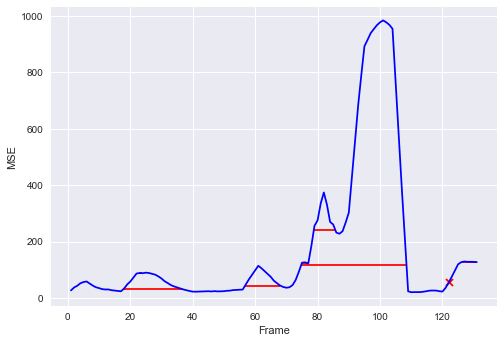

In [20]:
plt.style.use('seaborn')
plt.plot(mapped_landmarks_df.frame, windowized_mse, color='blue')
#plt.title(f'MSE of video "{video_name}"')
plt.xlabel('Frame')
plt.ylabel('MSE')

threshold = 75
peaks, _ = find_peaks(windowized_mse, height=threshold)
widths = peak_widths(windowized_mse, peaks, rel_height=0.90)


first_frame = mapped_landmarks_df.frame.iloc[0]
for frames in widths[2:]:
    frames += first_frame # add the starting frame of the video
    
plt.hlines(*widths[1:], color="red")


start_frame, end_frame = None, None
if windowized_mse[0]>threshold:
    for index, mse_value in enumerate(windowized_mse):
        if mse_value < threshold:
            start_frame = index+first_frame
            break
    
if windowized_mse[-1]>threshold:
    for index in range(len(windowized_mse)-1, -1, -1):
        if windowized_mse[index] < threshold:
            end_frame = index+first_frame
            break

if start_frame:
    plt.scatter(start_frame, windowized_mse[start_frame], marker="x", color="red")

if end_frame:
    plt.scatter(end_frame, windowized_mse[end_frame-first_frame], marker="x", color="red")
    
plt.show()

### Landmark interpolation and data cleansing

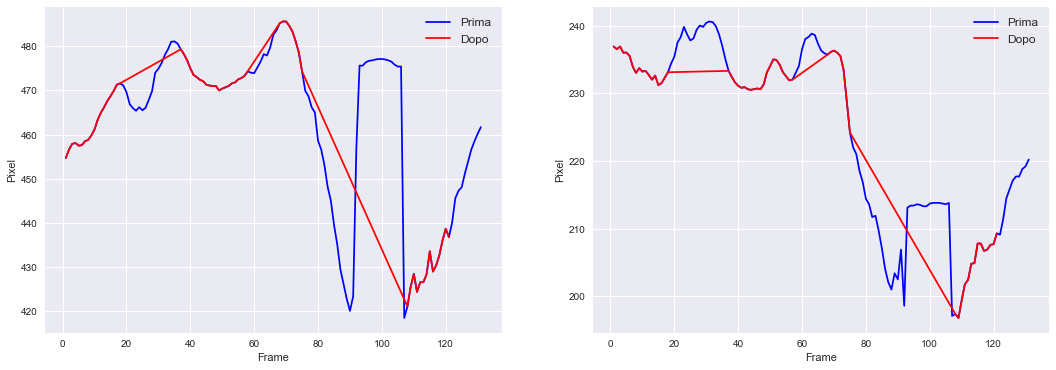

In [21]:
openface_df = pd.read_csv(f'../openFace/train/processed/{video_name}_openface.csv')

_, axes = plt.subplots(1, 2, figsize=(18,6))
axes = axes.flatten()

#axes[0].set(title='X Coordinate', xlabel='Frame', ylabel='Pixel')
#axes[1].set(title='Y Coordinate', xlabel='Frame', ylabel='Pixel')

axes[0].set(xlabel='Frame', ylabel='Pixel')
axes[1].set(xlabel='Frame', ylabel='Pixel')

axes[0].plot(openface_df.frame, openface_df.x_40, color='blue', label='Prima')
axes[1].plot(openface_df.frame, openface_df.y_40, color='blue', label='Prima')

if start_frame:
    openface_df.drop([frame for frame in range(start_frame-first_frame+1)], inplace=True)
    mediapipe_df.drop([frame for frame in range(start_frame-first_frame+1)], inplace=True)
    
if end_frame:
    openface_df.drop([frame for frame in range(end_frame-first_frame, openface_df.frame.iloc[-1]-first_frame+1)], inplace=True)
    mediapipe_df.drop([frame for frame in range(end_frame-first_frame, int(mediapipe_df.frame.iloc[-1])-first_frame+1)], inplace=True)

starting_points = widths[2]
ending_points = widths[3]

for peak_points in zip(starting_points, ending_points):
    
    start = round(peak_points[0])
    end = round(peak_points[1])
    
    for i in range(68):
        openface_df.loc[start:end-2, f'x_{i}'], openface_df.loc[start:end-2, f'y_{i}'] = np.nan, np.nan
openface_df.interpolate(method='linear', axis=0, inplace=True)
      
axes[0].plot(openface_df.frame, openface_df.x_40, color='red', label='Dopo')
axes[1].plot(openface_df.frame, openface_df.y_40, color='red', label='Dopo')

axes[0].legend(fontsize='large')
axes[1].legend(fontsize='large')
plt.show()

### Visualization of the interpolated landmarks

In [22]:
def draw_landmark(image, landmarks_df, frame):
    
    x_regex_pat = re.compile(r'^frame$|^x_[0-9]+$')
    y_regex_pat = re.compile(r'^frame$|^y_[0-9]+$')
    
    x_locs = landmarks_df.columns[landmarks_df.columns.str.contains(x_regex_pat)]
    y_locs = landmarks_df.columns[landmarks_df.columns.str.contains(y_regex_pat)]
    
    image.flags.writeable = True
    
    x_i = landmarks_df[x_locs][landmarks_df.frame==frame]
    y_i = landmarks_df[y_locs][landmarks_df.frame==frame]
    
    x_i.drop('frame', axis=1, inplace=True)
    y_i.drop('frame', axis=1, inplace=True)
    
    x_i = x_i.squeeze()
    y_i = y_i.squeeze()
    
    for i in range(68):
        x, y = round(x_i[i]), round(y_i[i])
        image[y,x-1] = [255,0,0]
        image[y,x+1] = [255,0,0]
        image[y-1,x] = [255,0,0]
        image[y+1,x] = [255,0,0]
        
        image[y,x] = [255,0,0]
        image[y+1,x+1] = [255,0,0]
        image[y-1,x-1] = [255,0,0]
        image[y+1,x-1] = [255,0,0]
        image[y-1,x+1] = [255,0,0]
        
        image[y+2,x+2] = [255,0,0]
        image[y-2,x-2] = [255,0,0]
        image[y+2,x-2] = [255,0,0]
        image[y-2,x+2] = [255,0,0]
        
        image[y,x-2] = [255,0,0]
        image[y,x+2] = [255,0,0]
        image[y-2,x] = [255,0,0]
        image[y+2,x] = [255,0,0]
        
        image[y+1,x-2] = [255,0,0]
        image[y+1,x+2] = [255,0,0]
        image[y-1,x+2] = [255,0,0]
        image[y+1,x-2] = [255,0,0]
        
    return

In [23]:
baseDir = '../dataset/ElderReact_Data/ElderReact_train/'

fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
cap = cv2.VideoCapture(baseDir + video_name + '.mp4')
out = cv2.VideoWriter('/home/filippo/Downloads/output_interpolated.avi', fourcc, 24.0, (650,720))
frame = 1

while cap.isOpened():
    success, image = cap.read()
    if not success: break
    if frame >= openface_df.frame.iloc[-1]: break
    
    if frame >= openface_df.frame.iloc[0]:
        image.flags.writeable = False
        draw_landmark(image, openface_df, frame)
        
    out.write(image)
    frame+=1
    cv2.imshow(f'{video_name}', image)
    cv2.waitKey(20)

cap.release()
out.release()
cv2.destroyAllWindows()